In [1]:
!pip install opendatasets
import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 
import os 
import warnings
from random import shuffle 
from tqdm import tqdm 
from PIL import Image
warnings.filterwarnings('ignore')

in_path = '/content/chest-xray-pneumonia/chest_xray/chest_xray'

In [3]:
od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: peihanl
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [00:22<00:00, 108MB/s]


In [6]:
image_size = 150

train_data_log = []
train_labels_log = []

in_path = '/content/chest-xray-pneumonia/chest_xray/chest_xray/'
for normal_image in tqdm(os.listdir(in_path + 'train' + '/NORMAL/')): 
    path = os.path.join(in_path + 'train' + '/NORMAL/', normal_image)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
    if img is None:
        continue
    img = cv2.resize(img, (image_size, image_size)).flatten()   
    np_img=np.asarray(img)
    train_data_log.append(img)
    train_labels_log.append(0)
    
for pneumonia_image in tqdm(os.listdir(in_path + 'train' + '/PNEUMONIA/')): 
    path = os.path.join(in_path + 'train' + '/PNEUMONIA/', pneumonia_image)
    img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
    if img2 is None:
        continue
    img2 = cv2.resize(img2, (image_size, image_size)).flatten() 
    np_img2=np.asarray(img2)
    train_data_log.append(img2)
    train_labels_log.append(1)

100%|██████████| 3876/3876 [00:24<00:00, 159.43it/s]


In [7]:
train_data_log[0].shape

(22500,)

In [8]:
test_data_log = []
test_labels_log = []

for normal_image in tqdm(os.listdir(in_path + 'test' + '/NORMAL/')): 
    path = os.path.join(in_path + 'test' + '/NORMAL/', normal_image)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
    if img is None:
        continue
    img = cv2.resize(img, (image_size, image_size)).flatten()   
    np_img=np.asarray(img)
    test_data_log.append(img)
    test_labels_log.append(0)
    
for pneumonia_image in tqdm(os.listdir(in_path + 'test' + '/PNEUMONIA/')): 
    path = os.path.join(in_path + 'test' + '/PNEUMONIA/', pneumonia_image)
    img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
    if img2 is None:
        continue
    img2 = cv2.resize(img2, (image_size, image_size)).flatten() 
    np_img2=np.asarray(img2)
    test_data_log.append(img2)
    test_labels_log.append(1)

100%|██████████| 390/390 [00:02<00:00, 179.77it/s]


In [9]:
train_data = np.array(train_data_log).T
train_labels = np.array(train_labels_log).reshape(-1, 1).T
test_data = np.array(test_data_log).T
test_labels = np.array(test_labels_log).reshape(-1, 1).T

train_data = (train_data-np.min(train_data))/(np.max(train_data)-np.min(train_data))
test_data = (test_data-np.min(test_data))/(np.max(test_data)-np.min(test_data))

print("Train data shape: {}".format(train_data.shape))
print("Train labels shape: {}".format(train_labels.shape))
print("Test data shape: {}".format(test_data.shape))
print("Test labels shape: {}".format(test_labels.shape))

Train data shape: (22500, 5216)
Train labels shape: (1, 5216)
Test data shape: (22500, 624)
Test labels shape: (1, 624)


In [10]:
def sigm(x):
    return 1/(1+np.exp(-x))

In [11]:
def propagate(w,b,train_data,train_labels):
    y = sigm(np.dot(w.T,train_data) + b)
    loss = -train_labels*np.log(y)-(1-train_labels)*np.log(1-y)
    cost = (np.sum(loss))/train_data.shape[1]
    dW = (np.dot(train_data,((y-train_labels).T)))/train_data.shape[1]
    dB = np.sum(y-train_labels)/train_data.shape[1]
    return cost, {"dW": dW,"dB": dB}

In [12]:
def update(w, b, train_data, train_labels, learning_rate, max_iter):
    costs = []
    costs2 = []
    index = []
    
    for i in range(max_iter):
        cost, deltas = propagate(w,b,train_data,train_labels)
        costs.append(cost)
        w = w - learning_rate * deltas["dW"]
        b = b - learning_rate * deltas["dB"]
        
        if i % 50 == 0 and i != 0:
            costs2.append(cost)
            index.append(i)
            print("Iteration {} > cost = {}".format(i, cost))
    
    plt.plot(index,costs2)
    plt.xticks(index)
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.show()
    return {"w": w,"b": b}, deltas, costs

In [13]:
def predict(w, b, test_data):
    z = sigm(np.dot(w.T, test_data)+b)
    pred = np.zeros((1, test_data.shape[1]))
    for i in range(z.shape[1]):
        if z[0,i] <= 0.5:
            pred[0,i] = 0
        else:
            pred[0,i] = 1
    return pred

In [14]:
def log_regression(train_data, train_labels, test_data, test_labels, learning_rate, max_iter):
    dim =  train_data.shape[0]
    w = np.full((dim,1),0.01)
    b = 0.0

    params, gradients, cost_list = update(w, b, train_data, train_labels, learning_rate, max_iter)
    
    test_labels_prediction = predict(params["w"],params["b"],test_data)
    train_labels_prediction = predict(params["w"],params["b"],train_data)
    
    print("Test Accuracy: {} %".format(round(100 - np.mean(np.abs(test_labels_prediction - test_labels)) * 100,2)))
    print("Train Accuracy: {} %".format(round(100 - np.mean(np.abs(train_labels_prediction - train_labels)) * 100,2)))
    
    return test_labels_prediction

Iteration 50 > cost = nan
Iteration 100 > cost = 0.6768665575723896
Iteration 150 > cost = 0.510657087726437
Iteration 200 > cost = 0.4117509891974842
Iteration 250 > cost = 0.3543191691509255
Iteration 300 > cost = 0.31926841281102925
Iteration 350 > cost = 0.29604665194973445
Iteration 400 > cost = 0.2793188537995985
Iteration 450 > cost = 0.26638654639791115
Iteration 500 > cost = 0.25583630452238976
Iteration 550 > cost = 0.24689143781308215
Iteration 600 > cost = 0.23910189782917043
Iteration 650 > cost = 0.23219207113159893
Iteration 700 > cost = 0.22598339702112233
Iteration 750 > cost = 0.22035357988645124
Iteration 800 > cost = 0.21521434288334584
Iteration 850 > cost = 0.21049889710779324
Iteration 900 > cost = 0.20615465769466187
Iteration 950 > cost = 0.20213887128413852


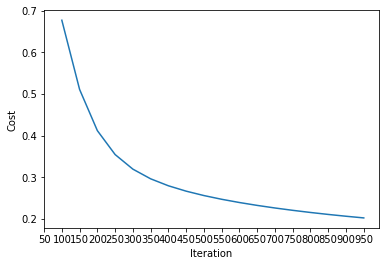

Test Accuracy: 77.24 %
Train Accuracy: 92.71 %


In [15]:
test_labels_prediction = log_regression(train_data, train_labels, test_data, test_labels, learning_rate = 0.001, max_iter = 1000)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_labels[0], test_labels_prediction[0]))

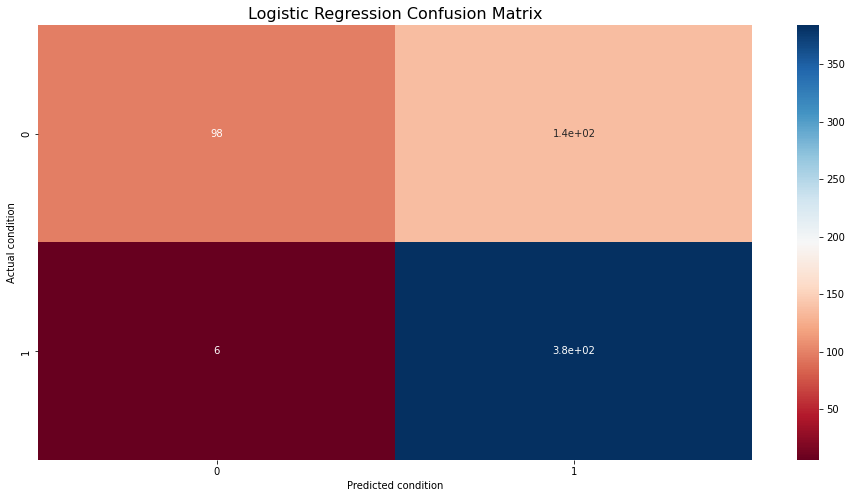

In [18]:
plt.figure(figsize=(16,8))
sns.heatmap(confusion_matrix_df, cmap="RdBu", annot=True)
plt.title('Logistic Regression Confusion Matrix', fontsize=16)
plt.xlabel("Predicted condition")
plt.ylabel("Actual condition")
plt.savefig("log_regression_confusion_matrix.png")
plt.show()

In [19]:
print(classification_report(test_labels[0], test_labels_prediction[0]))

              precision    recall  f1-score   support

           0       0.94      0.42      0.58       234
           1       0.74      0.98      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.70      0.71       624
weighted avg       0.81      0.77      0.74       624

